<a href="https://colab.research.google.com/github/mahsasheikh/HybGen/blob/main/HybGen_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HybGen Docker**
A Jupyter Notebook based on AutoDock Vina 1.2.0 written to generate hybrid ligands and perform ✨**fully automated**✨ docking simulation.  

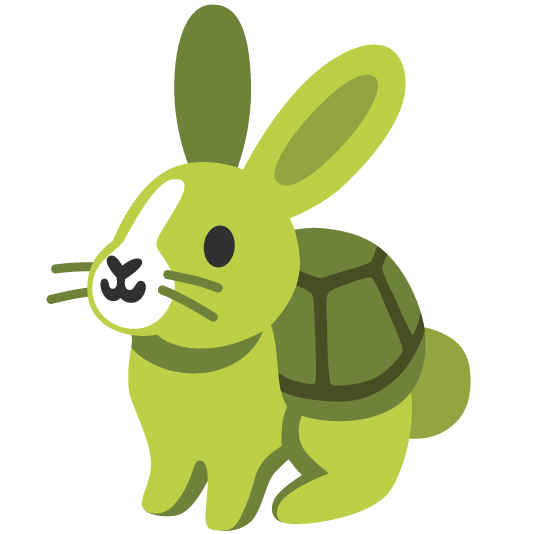

---
---
# **Setting up the Environment for Molecular Docking**

Before starting, we need to install all the necessary software and dependecies to perform molecular docking.

+ condacolab (https://github.com/conda-incubator/condacolab)
+ MGLtools (https://ccsb.scripps.edu/mgltools/)
+ AutoDock Vina (https://vina.scripps.edu/)
+ biopython (https://biopython.org/)
+ EasyDock (https://github.com/ci-lab-cz/easydock)
+ PDBFixer (https://github.com/openmm/pdbfixer)
+ RDKit (https://www.rdkit.org/)
+ LABODOCK (https://github.com/RyanZR/labodock/tree/main)

In [1]:
# @title Initializing Condacolab (kernel will restart)

!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:15
🔁 Restarting kernel...


In [1]:
# @title Check that everything is fine

import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [2]:
print('📦 Installing conda dependencies ...')
!conda install -c conda-forge rdkit pdbfixer > /dev/null

📦 Installing conda dependencies ...


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.7.1

Please update conda by running

    $ conda update -n base -c conda-forge conda




In [ ]:
# @title Installing dependencies and packages (this might take around 20 minutes)
print('🔥 Installing PyTorch and PyG ...')
!pip install torch==1.13.1+cpu -f https://download.pytorch.org/whl/cpu/torch_stable.html > /dev/null
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.1+cpu.html > /dev/null
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.1+cpu.html > /dev/null
!pip install torch-spline-conv torch-geometric==2.0.1 -f https://data.pyg.org/whl/torch-1.13.1+cpu.html > /dev/null
!pip install cairosvg svgutils molvs > /dev/null
# Install other dependencies
!pip install rdkit-pypi
!pip install Bio
!pip install meeko
!pip install paramiko
!pip install easydock
print('✔️ Installing pkasolver package ...')
!pip install -q git+https://github.com/mayrf/pkasolver.git > /dev/null
print("🎉 Done!")

🔥 Installing PyTorch and PyG ...


In [ ]:
# @title Setup AutoDock Vina
!wget https://github.com/ccsb-scripps/AutoDock-Vina/releases/download/v1.2.0/vina_1.2.0_linux_x86_64 -O vina
!chmod u+x vina

In [ ]:
# @title **Import Python modules**

# Import modules
import os
import random
import sys
import numpy as np
import pandas as pd
from itertools import permutations, combinations
from IPython.display import display, Image
from rdkit.Chem import AllChem, Draw
from rdkit import RDLogger
import contextlib
import csv
from rdkit import Chem
import shutil
from pathlib import Path

# protonation modules
import tempfile

# get pdb
import requests
import xml.etree.ElementTree as ET
from Bio.PDB import PDBIO, PDBParser
from Bio import PDB

# PDBFixer
from pdbfixer import PDBFixer
from openmm.app import PDBFile


# ligand preparation
from easydock import preparation_for_docking
from easydock import read_input
from easydock import protonation


# lipinski modules
from rdkit.Chem.rdMolDescriptors import CalcNumLipinskiHBA, CalcNumLipinskiHBD, CalcExactMolWt, CalcCrippenDescriptors

# Capture python output
class Hide:
  def __enter__(self):
    self._original_stdout = sys.stdout
    sys.stdout = open(os.devnull, "w")

  def __exit__(self, exc_type, exc_val, exc_tb):
    sys.stdout.close()
    sys.stdout = self._original_stdout

# Define common variables

io = PDBIO()
parser = PDBParser()

print("> Installation done")
print("> Import done")
print("> Environment ready for docking")

In [ ]:
# @title **Setup alias for Vina**

%alias vina /content/vina

print("> Alias '%Vina' created")


In [ ]:
#@title **Enter the main smiles and respective uniprot id**

SMILES = "[O]c1c(C(N2CCN(CC2)C(C(c(c[nH]3)c4c3c(n5nc(C)nc5)ncc4OC)=O)=O)=O)cccc1" #@param {type:"string"}
PDB_ID = "" #@param {type:"string"}
chain_in_PDB = None #@param
uniprot = "q9y006" #@param {type:"string"}

---
---
# **Generating the Hybrids**

The first step in this study is to have a set of structures of a given ligand, hybridized with proper amino acids. We utilize the RDKit library for molecular manipulations and EasyDock for docking simulations. The core component of this method is the LigandBuilder class, which handles the creation of peptide bonds, removal of extra hydrogens, and the generation of ligands.


*This step is specifically designed for generating hybrids. If you're just interested in automatic docking feature, skip next three cells.*

In [ ]:
#@title **Choosing the Connection Point**

def get_all_atoms_in_molecule(molecule):
    """
    Get all atoms in the input molecule.

    This should be done before anything to define your connection point.

    Returns:
        IPython.core.display.Image object: Image displaying the molecule with atom indices.
    """
    # Create a drawing object with a specific size
    d = Draw.MolDraw2DCairo(800, 800)
    # Set the drawing options to show atom indices
    d.drawOptions().addAtomIndices = True
    # Draw the molecule
    d.DrawMolecule(molecule)
    d.FinishDrawing()
    # Get the image data
    data = d.GetDrawingText()
    # Display the image in the notebook
    return Image(data=data)

# Create a molecule from SMILES
molecule = Chem.MolFromSmiles(SMILES)
# Display the molecule with atom indices
display(get_all_atoms_in_molecule(molecule))

ligand_smiles = []

In [ ]:
#@title **Enter your connection point, amino acids and amino acid-like molecules**
#note that you either can have one non-peptide entry in the "other molecules" or several peptides in multiple sections
connection_site = 0 #@param
# choose N or C terminal of the peptides for connection point
# note that the connection site and the terminal should make chemical sense
terminal = "C" #@param {type:"string"}
L_sequence = "RQK" #@param {type:"string"}
D_sequence = "" #@param {type:"string"}
# provide a list
other_molecules = [] #@param

In [ ]:
# @title **Building Ligand**
from rdkit import Chem
from rdkit.Chem import rdChemReactions

logger = RDLogger.logger()
logger.setLevel(RDLogger.CRITICAL)


class LigandBuilder:
    def __init__(self):
        self.ligands = []


    def create_peptide_bond(self, mol1, mol2):
        """
        Create a peptide bond (amide bond) between two molecules.

        Args:
            mol1: First molecule.
            mol2: Second molecule.

        Returns:
            Combined molecule with a peptide bond, or None if the reaction fails.
        """
        # Define the reactions for creating a peptide bond
        reactions_H = [
            (Chem.MolFromSmarts("[C:1](=[O:2])[OH:3]"), Chem.MolFromSmarts("[N:4]"),
            '[C:1](=[O:2])[OH:3].[N:4]>>[C:1](=[O:2])[N:4]'),
            (Chem.MolFromSmarts("[N:4]"), Chem.MolFromSmarts("[C:1](=[O:2])[OH:3]"),
            '[N:4].[C:1](=[O:2])[OH:3]>>[C:1](=[O:2])[N:4]')
        ]
        reactions_noH = [
            (Chem.MolFromSmarts("[N:4]"), Chem.MolFromSmarts("[C:1](=[O:2])[O:3]"),
            '[N:4].[C:1](=[O:2])[O:3]>>[C:1](=[O:2])[N:4]'),
            (Chem.MolFromSmarts("[C:1](=[O:2])[O:3]"), Chem.MolFromSmarts("[N:4]"),
            '[C:1](=[O:2])[O:3].[N:4]>>[C:1](=[O:2])[N:4]')
        ]

        try:
            # First try reactions with -OH
            for smarts1, smarts2, rxn_smarts in reactions_H:
                if mol1.HasSubstructMatch(smarts1) and mol2.HasSubstructMatch(smarts2):
                    rxn = rdChemReactions.ReactionFromSmarts(rxn_smarts)
                    product_sets1 = rxn.RunReactants((mol1, mol2))
                    products1 = [p[0] for p in product_sets1 if p]

                    if products1:
                        return products1[0]




            # If no product found with -OH reactions, try reactions without -OH
            for smarts1, smarts2, rxn_smarts in reactions_noH:
                if mol1.HasSubstructMatch(smarts1) and mol2.HasSubstructMatch(smarts2):
                    rxn = rdChemReactions.ReactionFromSmarts(rxn_smarts)
                    product_sets3 = rxn.RunReactants((mol1, mol2))
                    products3 = [p[0] for p in product_sets3 if p]

                    if products3:
                        return products3[0]



            # If no product is found, return None
            print("No suitable reaction found for the given molecules.")
            return None

        except Exception as e:
            print(f"Error creating peptide bond: {e}")
            return None

    def add_hydrogens_and_sanitize(self, mol):
        try:
            mol = AllChem.AddHs(mol)
            Chem.SanitizeMol(mol)
            return mol
        except Exception as e:
            print(f"Error adding hydrogens or sanitizing molecule: {e}")
            return None


    def remove_extra_hydrogens(self, mol):
        # Remove all hydrogens
        mol = Chem.RemoveHs(mol, sanitize=False)

        for atom in mol.GetAtoms():
            if atom.GetSymbol() == 'N':
                valence = atom.GetTotalValence()
                # Nitrogen typically has a valence of 3 (three bonds)
                target_valence = 3
                # Calculate the number of explicit hydrogens needed
                explicit_hs_needed = target_valence - valence
                if explicit_hs_needed < 0:
                    explicit_hs_needed = 0
                # Add hydrogen atoms only to nitrogen atoms
                atom.SetNumExplicitHs(explicit_hs_needed)
                # Clear any lone pairs and radicals associated with the nitrogen atom
                atom.SetNumRadicalElectrons(0)
                atom.SetNoImplicit(True)


        return mol

    def handle_N_heterocycles(self, mol):
        if mol.HasSubstructMatch(Chem.MolFromSmarts("[#6]12:[#6]:[#6]:[#6]:[#6]:[#6]:1:[#6]:[#6]:[#7]:2")):
            # Get the atoms matching the SMARTS pattern
            matches = mol.GetSubstructMatches(Chem.MolFromSmarts("[#6]12:[#6]:[#6]:[#6]:[#6]:[#6]:1:[#6]:[#6]:[#7]:2"))
            for match in matches:
                # Get the nitrogen atom index from the match
                nitrogen_index = match[-1]  # Last atom in the match corresponds to the nitrogen atom
                # Add one explicit hydrogen to the nitrogen atom
                if mol.GetAtomWithIdx(nitrogen_index).GetTotalDegree() == 2:
                  mol.GetAtomWithIdx(nitrogen_index).SetNumExplicitHs(1)


        if mol.HasSubstructMatch(Chem.MolFromSmarts("[#6]1:[#7]:[#6]:[#7]:[#6]:1")):
            matches = mol.GetSubstructMatches(Chem.MolFromSmarts("[#6]1:[#7]:[#6]:[#7]:[#6]:1"))
            for match in matches:
                # Get the nitrogen atom index from the match
                nitrogen_index = match[-2]  # Last atom in the match corresponds to the nitrogen atom
                # Add one explicit hydrogen to the nitrogen atom
                if mol.GetAtomWithIdx(nitrogen_index).GetTotalDegree() == 2:
                  mol.GetAtomWithIdx(nitrogen_index).SetNumExplicitHs(1)
                  break
        if mol.HasSubstructMatch(Chem.MolFromSmarts("[#6]1:[#6]:[#7]:[#6]:[#6]:1")):
            matches = mol.GetSubstructMatches(Chem.MolFromSmarts("[#6]1:[#6]:[#7]:[#6]:[#6]:1"))
            for match in matches:
                # Get the nitrogen atom index from the match
                nitrogen_index = match[-3]  # Last atom in the match corresponds to the nitrogen atom
                # Add one explicit hydrogen to the nitrogen atom
                if mol.GetAtomWithIdx(nitrogen_index).GetTotalDegree() == 2:
                  mol.GetAtomWithIdx(nitrogen_index).SetNumExplicitHs(1)

        if mol.HasSubstructMatch(Chem.MolFromSmarts("[#6]12:[#7]:[#6]:[#7]:[#6]:[#6]:1:[#7]:[#6]:[#7]:2")):
            matches = mol.GetSubstructMatches(Chem.MolFromSmarts("[#6]12:[#7]:[#6]:[#7]:[#6]:[#6]:1:[#7]:[#6]:[#7]:2"))
            for match in matches:
                # Get the nitrogen atom index from the match
                nitrogen_index = match[-1]  # Last atom in the match corresponds to the nitrogen atom
                # Add one explicit hydrogen to the nitrogen atom
                if mol.GetAtomWithIdx(nitrogen_index).GetTotalDegree() == 2:
                  mol.GetAtomWithIdx(nitrogen_index).SetNumExplicitHs(1)

        if mol.HasSubstructMatch(Chem.MolFromSmarts("[#6]1:[#7]:[#7]:[#7]:[#6]:1")):
            matches = mol.GetSubstructMatches(Chem.MolFromSmarts("[#6]1:[#7]:[#7]:[#7]:[#6]:1"))
            for match in matches:
                # Get the nitrogen atom index from the match
                nitrogen_index = match[-2]  # Last atom in the match corresponds to the nitrogen atom
                # Add one explicit hydrogen to the nitrogen atom
                if mol.GetAtomWithIdx(nitrogen_index).GetTotalDegree() == 2:
                  mol.GetAtomWithIdx(nitrogen_index).SetNumExplicitHs(1)


        if mol.HasSubstructMatch(Chem.MolFromSmarts("[#6]1:[#7]:[#7]:[#7]:[#7]:1")):
            matches = mol.GetSubstructMatches(Chem.MolFromSmarts("[#6]1:[#7]:[#7]:[#7]:[#7]:1"))
            for match in matches:
                # Get the nitrogen atom index from the match
                nitrogen_index = match[-1]  # Last atom in the match corresponds to the nitrogen atom
                # Add one explicit hydrogen to the nitrogen atom
                if mol.GetAtomWithIdx(nitrogen_index).GetTotalDegree() == 2:
                  mol.GetAtomWithIdx(nitrogen_index).SetNumExplicitHs(1)

        if mol.HasSubstructMatch(Chem.MolFromSmarts("[#6]1:[#6]:[#7]:[#7]:[#6]:1")):
            # Get the atoms matching the SMARTS pattern
            matches = mol.GetSubstructMatches(Chem.MolFromSmarts("[#6]1:[#6]:[#7]:[#7]:[#6]:1"))
            for match in matches:
                # Get the nitrogen atom index from the match
                nitrogen_index = match[-2]  # Last atom in the match corresponds to the nitrogen atom
                # Add one explicit hydrogen to the nitrogen atom
                if mol.GetAtomWithIdx(nitrogen_index).GetTotalDegree() == 2:
                  mol.GetAtomWithIdx(nitrogen_index).SetNumExplicitHs(1)
        return mol

    def input_amino_acids(self, l_sequence, d_sequence, other_aminoacids):
        """
        Input amino acids from strings of L- and D-sequences and create all combinations with peptide bonds.

        Args:
            l_sequence (str): sequence representing L-amino acids.
            d_sequence (str): sequence representing D-amino acids.
            other_aminoacids (list): other amino acids or molecules
        """
        # Create RDKit molecules from L- and D-sequences
        l_mols = [Chem.rdmolfiles.MolFromFASTA(f'>{aa.upper()}\n{aa.upper()}') for aa in l_sequence if aa]
        d_mols = [Chem.rdmolfiles.MolFromFASTA(f'>{aa.lower()}\n{aa.lower()}', flavor=1) for aa in d_sequence if aa]
        other_mols = [self.add_hydrogens_and_sanitize(Chem.MolFromSmiles(n)) for n in other_aminoacids if n]
        ohter_smiles = [Chem.MolToSmiles(n) for n in other_mols]
        print(ohter_smiles)

        all_mols = []
        if l_mols:
            all_mols.extend(l_mols)
        if d_mols:
            all_mols.extend(d_mols)
        if other_mols:
            all_mols.extend(other_mols)

        # Create all combinations and permutations of the molecules
        unique_smiles = set()
        self.amino_acid_arrangements = []
        for r in range(1, len(all_mols) + 1):
            for combo in combinations(all_mols, r):
                for perm in permutations(combo):
                    # Create a peptide chain by adding peptide bonds
                    peptide = perm[0]
                    for mol in perm[1:]:
                      peptide = self.create_peptide_bond(peptide, mol)

                    try:
                      # Sanitize the molecule
                      Chem.SanitizeMol(peptide)

                      # Add hydrogens
                      peptide = Chem.AddHs(peptide)

                      # Get the canonical SMILES string of the combined molecule
                      smiles = Chem.MolToSmiles(peptide, isomericSmiles=True)

                      # Add to the set if it's unique
                      if smiles not in unique_smiles:
                          unique_smiles.add(smiles)
                          self.amino_acid_arrangements.append(peptide)
                    except Exception as e:
                      print('finding right molecule combinations...')


    def input_molecule(self, molecule_smiles):
        """
        Input a molecule structure from a SMILES string.

        Args:
            molecule_smiles (str): SMILES string of the molecule.
        """
        try:
            self.molecule = Chem.MolFromSmiles(molecule_smiles)
            Chem.SanitizeMol(self.molecule)  # Ensure the molecule is sanitized
            AllChem.Compute2DCoords(self.molecule)
        except Exception as e:
            raise ValueError("Error reading SMILES string:", e)

    def find_connection_points(self, molecule, smarts_pattern="[NH2,NH]"):
        """
        Find all atom indices matching the SMARTS pattern in the given molecule.

        Args:
            molecule (RDKit Mol object): Molecule to search.
            smarts_pattern (str): SMARTS pattern to match.

        Returns:
            List of atom indices.
        """
        query = Chem.MolFromSmarts(smarts_pattern)
        if query is None:
            raise ValueError(f"Invalid SMARTS pattern: {smarts_pattern}")

        matches = molecule.GetSubstructMatches(query)
        connection_points = [match[0] for match in matches]
        return connection_points

    def AddCs(self, connection_site):
        Chem.SanitizeMol(self.molecule)
        edit_mol = Chem.EditableMol(self.molecule)
        edit_mol.AddAtom(Chem.Atom(55))  # 55 is the atomic number for Cesium
        edit_mol.AddBond(connection_site, self.molecule.GetNumAtoms(), Chem.BondType.SINGLE)
        self.molecule = edit_mol.GetMol()
        Chem.RemoveHs(self.molecule, sanitize = False)
        return self.molecule

    def generate_ligands(self, connection_site, terminal):
        """
        Generate all possible ligand arrangements from the input amino acids and molecule.

        Args:
            connection_site (int): index of the atom in your ligand which the amino acid
                                   sequence will be attached to
            terminal (str): should be either C or N. C if you want your peptide to attach
                            from C terminal and N if you want it to attach from N terminal.
        """
        if not hasattr(self, 'amino_acid_arrangements') or not hasattr(self, 'molecule'):
            raise ValueError("Amino acids and molecule must be input before generating ligands.")

        if terminal == 'C':
            # Generate ligands by combining amino acids with the molecule
            self.ligands = []
            for arrangement in self.amino_acid_arrangements:
                # Copy the molecule
                ligand = Chem.Mol(self.molecule)
                # Define SMARTS patterns for relevant functional groups

                replacement_result = Chem.ReplaceSubstructs(arrangement, Chem.MolFromSmarts("[OH]"), ligand,
                                                            replacementConnectionPoint=connection_site)
                self.ligands.append(replacement_result)
        elif terminal == 'N':
            ModifiedLigand = self.AddCs(connection_site)
            self.ligands = []
            for arrangement in self.amino_acid_arrangements:
                connection_points = self.find_connection_points(arrangement)
                for connection_point in connection_points:
                    # Copy the molecule
                    ligand = Chem.Mol(ModifiedLigand)
                    # Define SMARTS patterns for relevant functional groups
                    # Choose "[Cs]", "[OCs]", etc. to be replaced. If you need any other substructure, feel free to include it.

                    replacement_result = Chem.ReplaceSubstructs(ligand, Chem.MolFromSmarts("[Cs]"), arrangement,
                                                                replacementConnectionPoint=connection_point)
                    self.ligands.append(replacement_result)
        else:
            raise ValueError("The argument terminal should be either C or N.")

        self.ligand_smiles = []
        for i, ligand_tuple in enumerate(self.ligands):
            for ligand in ligand_tuple:
              if ligand != "":
                ligand = self.remove_extra_hydrogens(ligand)
                ligand = self.handle_N_heterocycles(ligand)
                Chem.SanitizeMol(ligand)
                smiles = Chem.MolToSmiles(ligand)
                print("1 new ligand smiles generated.")
                self.ligand_smiles.append(smiles)
        return self.ligand_smiles


# Example usage


builder = LigandBuilder()

# Process the input
builder.input_amino_acids(L_sequence, D_sequence, other_molecules)
builder.input_molecule(SMILES)

# Generate ligands
ligand_smiles = builder.generate_ligands(connection_site, terminal)
print(f"{len(ligand_smiles)} ligands generated.")

for i in ligand_smiles:
  print(i)


In [ ]:
#@title if you don't want to make hybrids and just want to dock original ligand, run this.
if not ligand_smiles:
  ligand_smiles = [SMILES]

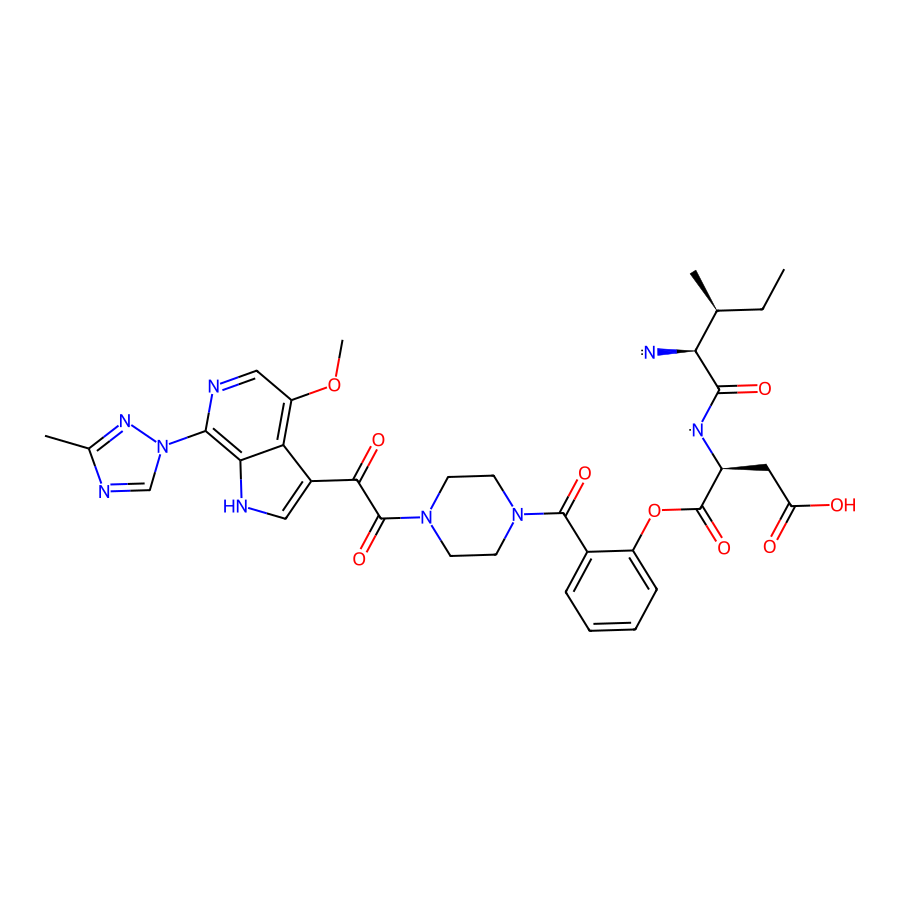

In [ ]:
#@title **display an example**

# Select a random SMILE from the list
random_smile = random.choice(ligand_smiles)

# Create a molecule object from the SMILE
molecule = Chem.MolFromSmiles(ligand_smiles[16])

# Display the molecule
Draw.MolToImage(molecule, size=(900, 900))


In [ ]:
if uniprot:
  Jobname = f"{uniprot}_docking"
else:
  Jobname = f"{PDB_ID}_docking"
dir = os.path.abspath(".")
work_dir = os.path.join(dir, Jobname)
protein_folder = os.path.join(work_dir, "protein")
ligand_folder = os.path.join(work_dir, "ligand")
experimental_folder = os.path.join(work_dir, "experimental")
docking_folder = os.path.join(work_dir, "docking")


# Create folder if folder have not exists
folder = [work_dir, protein_folder, ligand_folder, docking_folder]
for f in folder:
  if os.path.exists(f):
    print("> %s already exists" % f)
  if not os.path.exists(f):
    os.mkdir(f)
    print("> %s was successfully created" % f)

> /content/3CGT_docking was successfully created
> /content/3CGT_docking/protein was successfully created
> /content/3CGT_docking/ligand was successfully created
> /content/3CGT_docking/docking was successfully created


---
---
# **Preparing the Protein**

The first step in docking is to have a structure of a given target protein. While in some cases a high-quality comparative model will be used, most cases start with an experimentally (X-ray, NMR, cryoEM) solved three-dimensional structure. We can either use uniprot API to select the PDB file and chain or enter them directly.
In these cases, a given target protein structure can be downloaded with BioPython using a given accession ID.  We can directly download this structure in `.pdb` file format.

In addition, we calculate the centroid of the chain in this step, in order to use in further calculations.

In [ ]:
# get pdb
import requests
import xml.etree.ElementTree as ET
from Bio.PDB import PDBIO, PDBParser
from Bio import PDB
from pdbfixer import PDBFixer
from openmm.app import PDBFile
import pandas as pd
import os
import numpy as np
import shutil

class SelectChains(PDB.Select):
    """Accepts or rejects chains based on their chain IDs."""
    def __init__(self, chain_letters):
        """Initialize with a list of chain IDs to accept."""
        self.chain_letters = chain_letters

    def accept_chain(self, chain):
        """Accepts a chain if its ID is in the list of accepted IDs."""
        return chain.get_id() in self.chain_letters

class Get_PDB:
    """Class for fetching and processing PDB files."""
    def __init__(self, directory, uniprot_id=None, pdb_id=None, chain=None):
        """Initialize with directory path and optional UniProt ID, PDB ID, and chain ID."""
        self.uniprot_id = uniprot_id
        self.pdb_id = pdb_id
        self.chain = chain
        self.directory = directory
        self.PDB_DOWNLOAD_PATH = os.path.join(directory, "pdbs")
        self.CLEAN_PDBS_PATH = directory
        os.makedirs(self.PDB_DOWNLOAD_PATH, exist_ok=True)
        os.makedirs(self.CLEAN_PDBS_PATH, exist_ok=True)

    def fetch_uniprot_data(self):
        """Fetch UniProt data for a given UniProt ID."""
        if not self.uniprot_id:
            return None
        url = f"https://www.uniprot.org/uniprot/{self.uniprot_id}.xml"
        response = requests.get(url)
        if response.status_code == 200:
            return response.text
        else:
            print(f"Error fetching data from UniProt: {response.status_code}")
            return None

    def parse_pdb_entries(self, xml_data):
        """Parse PDB entries from UniProt XML data."""
        root = ET.fromstring(xml_data)
        pdbs = []
        for db_ref in root.findall(".//{http://uniprot.org/uniprot}dbReference[@type='PDB']"):
            pdb = db_ref.attrib['id']
            method_element = db_ref.find(".//{http://uniprot.org/uniprot}property[@type='method']")
            resolution_element = db_ref.find(".//{http://uniprot.org/uniprot}property[@type='resolution']")
            chains_element = db_ref.find(".//{http://uniprot.org/uniprot}property[@type='chains']")
            if method_element is not None and resolution_element is not None:
                method = method_element.attrib['value']
                resolution = float(resolution_element.attrib['value'].split()[0])
                chain_details = self.parse_chain_details(chains_element)
                if chain_details:
                    chain_details.sort(key=lambda x: x[1], reverse=True)
                    pdbs.append((pdb, chain_details[0][0], chain_details[0][1], resolution, method))
                else:
                    pdbs.append((pdb, 'NA', 0, resolution, method))
        return pdbs

    def parse_chain_details(self, chains_element):
        """Parse chain details from UniProt XML data."""
        chain_details = []
        if chains_element is not None:
            chains_info = chains_element.attrib['value'].split(',')
            for chain_detail in chains_info:
                try:
                    chain, range_ = chain_detail.strip().split('=')
                    chain = chain.split('/')[0]
                    start, end = range_.split('-')
                    aa_count = int(end) - int(start) + 1
                    chain_details.append((chain, aa_count))
                except ValueError:
                    print(f"Skipping chain detail due to unexpected format: {chain_detail}")
        return chain_details

    def select_best_pdb(self, pdbs):
        """Select the best PDB entry based on chain length and resolution."""
        if not pdbs:
            return None
        pdbs.sort(key=lambda x: (-x[2], x[3]))
        return pdbs[0]

    def process_uniprot_id(self):
        """Process UniProt ID, fetch PDB data, and select the best PDB entry."""
        xml_data = self.fetch_uniprot_data()
        if xml_data:
            pdbs = self.parse_pdb_entries(xml_data)
            if pdbs:
                return self.select_best_pdb(pdbs)
        return None

    def calculate_centroid(self, structure):
        """Calculate the centroid of a PDB structure."""
        atom_coords = [atom.get_coord() for atom in structure.get_atoms()]
        return np.mean(atom_coords, axis=0)

    def make_pdb(self, pdb_path, chain_letters, base_dir=None, overwrite=True, struct=None):
        """Extract a specific chain from a PDB file and save it to a temporary directory."""
        self.parser = PDB.PDBParser()
        self.writer = PDB.PDBIO()
        self.base_dir = base_dir if base_dir else self.directory
        if isinstance(chain_letters, str):
            chain_letters = [chain_letters]  # Ensure it's iterable

        out_name = f"{self.pdb_id}_{''.join(chain_letters)}.ent"
        out_path = os.path.join(self.base_dir, "pdbs", out_name)  # Temporary outputs to directory/pdbs

        if not overwrite and os.path.exists(out_path):
            print(f"Chain {','.join(chain_letters)} of '{self.pdb_id}' already extracted to '{out_name}'.")
            return out_path

        print(f"Extracting chain {','.join(chain_letters)} from {self.pdb_id}...")
        if struct is None:
            struct = self.parser.get_structure(self.pdb_id, pdb_path)

        self.writer.set_structure(struct)
        self.writer.save(out_path, select=SelectChains(chain_letters))
        print("Other chain removed ...")

        pdb = self.parser.get_structure(self.pdb_id, out_path)
        io = PDB.PDBIO()
        io.set_structure(pdb)
        clean_path = os.path.join(self.CLEAN_PDBS_PATH,
                                  f"receptor_{self.pdb_id}_{''.join(chain_letters)}-cl.pdb")  # Final output to CLEAN_PDBS_PATH
        io.save(clean_path)

        struct = self.parser.get_structure(self.pdb_id, clean_path)
        centroid = self.calculate_centroid(struct)
        centroid_info = f"REMARK Centroid X: {centroid[0]:.3f} Y: {centroid[1]:.3f} Z: {centroid[2]:.3f}\n" # add centroid to PDB file

        with open(clean_path, 'r+') as file:
            content = file.readlines()
            content.insert(0, centroid_info)
            file.seek(0)
            file.writelines(content)

        print("Het atoms removed and centroid added...")
        return clean_path, self.CLEAN_PDBS_PATH, centroid


    def pdbfixer(self, clean_path, CLEAN_PDBS_PATH, centroid):
        """Use PDBFixer to fix missing atoms and residues in a PDB file."""
        fixer = PDBFixer(filename=clean_path)
        fixer.findMissingResidues()
        fixer.findNonstandardResidues()
        fixer.replaceNonstandardResidues()
        fixer.removeHeterogens(False)
        fixer.findMissingAtoms()
        fixer.addMissingAtoms()
        fixed_path = os.path.join(CLEAN_PDBS_PATH, f"{os.path.basename(clean_path).split('.')[0]}-fixed.pdb")
        PDBFile.writeFile(fixer.topology, fixer.positions, open(fixed_path, 'w'))

        centroid_info = f"REMARK Centroid X: {centroid[0]:.3f} Y: {centroid[1]:.3f} Z: {centroid[2]:.3f}\n"
        with open(fixed_path, 'r+') as file:
            content = file.readlines()
            content.insert(0, centroid_info)
            file.seek(0)
            file.writelines(content)

        print(f"PDB file fixed in {fixed_path}")

    def get_pdb_from_uniprot(self):
        pdb_data = self.process_uniprot_id()
        if not pdb_data:
            print("Skipping entry because of missing PDB data.")
            return None, None

        self.pdb_id, self.chain = pdb_data[:2]

        if not self.pdb_id or not self.chain:
            print("Skipping entry because of missing PDB ID or Chain.")
            return None, None
        else:
            print(f"Processing PDB ID {self.pdb_id} with chain {self.chain}...")
            try:
                pdb_fn =  PDB.PDBList().retrieve_pdb_file(self.pdb_id, pdir=self.PDB_DOWNLOAD_PATH, file_format='pdb')
                clean_path, CLEAN_PDBS_PATH, centroid = self.make_pdb(pdb_fn, self.chain)
                self.pdbfixer(clean_path, self.CLEAN_PDBS_PATH, centroid)
                return self.pdb_id, self.chain
            except Exception as e:
                print(f"Error processing PDB ID {self.pdb_id} with chain {self.chain}: {e}")
                return None, None


    def get_pdb_from_PDB(self):
        if not self.pdb_id or not self.chain:
            print("Skipping entry because no PDB or chain was enterd.")
            return None, None
        else:
            print(f"Processing PDB ID {self.pdb_id} with chain {self.chain}...")
            try:
                pdb_fn =  PDB.PDBList().retrieve_pdb_file(self.pdb_id, pdir=self.PDB_DOWNLOAD_PATH, file_format='pdb')
                clean_path, CLEAN_PDBS_PATH, centroid = self.make_pdb(pdb_fn, self.chain)
                self.pdbfixer(clean_path, self.CLEAN_PDBS_PATH, centroid)
                return self.pdb_id, self.chain
            except Exception as e:
                print(f"Error processing PDB ID {self.pdb_id} with chain {self.chain}: {e}")
                return None, None


# get_pdb_instance = Get_PDB(directory=protein_folder, uniprot_id=uniprot, pdb_id=PDB_ID, chain=chain_in_PDB)
# PDB_ID, chain = get_pdb_instance.get_pdb_from_PDB()
get_pdb_instance = Get_PDB(directory=protein_folder, uniprot_id=uniprot)
PDB_ID, chain = get_pdb_instance.get_pdb_from_uniprot()


Processing PDB ID 3QVC with chain A...
Extracting chain A from 3QVC...
Other chain removed ...
Het atoms removed and centroid added...
PDB file fixed in /content/3CGT_docking/protein/receptor_3QVC_A-cl-fixed.pdb


---
---
# **Preparing the Ligand with easydock**
We now need to prepare the ligand that will be used for docking analysis. We will attempt to predict the docking pose onto the binding of target protein.


In [ ]:
#@title protonation loop
# Create temporary files with proper extensions
tmp_input_path = tempfile.NamedTemporaryFile(suffix=".smi", delete=False).name
tmp_output_path = tempfile.NamedTemporaryFile(suffix=".smi", delete=False).name

protonated_smiles = []
for ligand in ligand_smiles:
  # Write SMILES to input file
  with open(tmp_input_path, 'w') as tmp_input:
      tmp_input.write(ligand + '\n')  # Ensure correct format for SMILES

  # Protonate using PKASolver
  protonation.protonate_pkasolver(tmp_input_path, tmp_output_path)

  # Read protonated molecule from output file
  with open(tmp_output_path, 'r') as tmp_output:
      protonated_smile = tmp_output.read().strip()
      protonated_smiles.append(protonated_smile)

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to patch pandas - unable to change molecule rendering
[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.
/usr/local/lib/python3.10/site-packages/pkasolver/query.py:121: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float(np.average(consensus_r, axis=0)),
/usr/local/lib/python3.10/site-packages/pkasolver/query.py:122: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float(np.std(consensus_r, axis=0)),


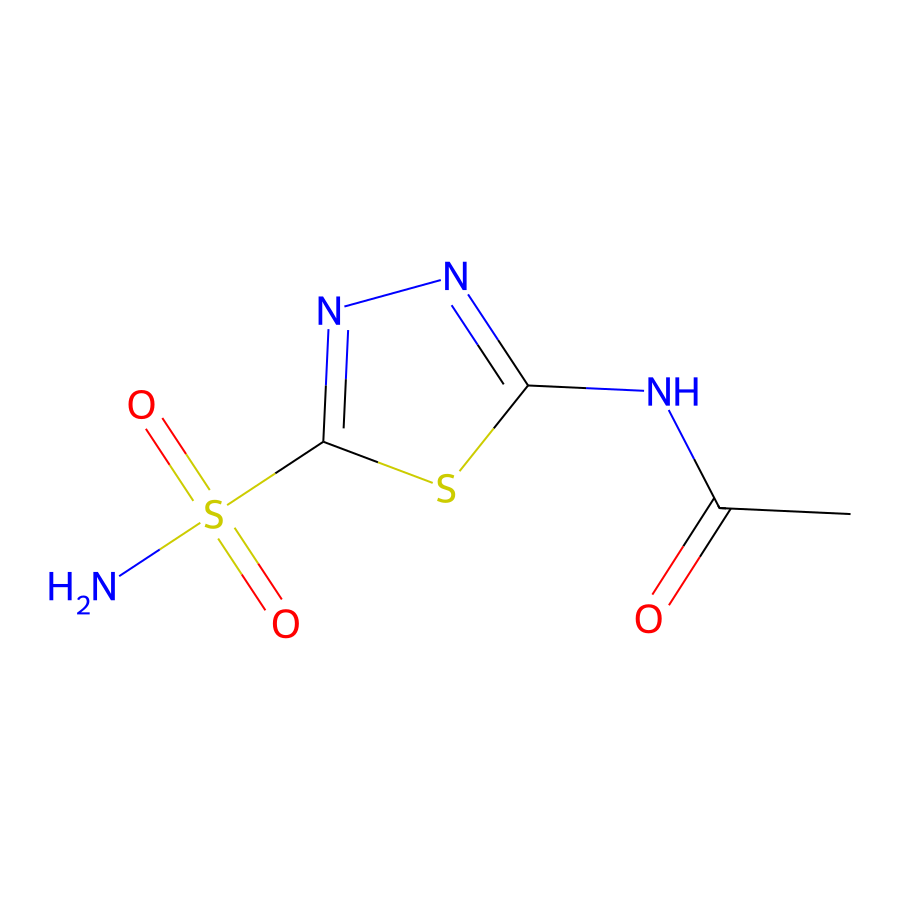

In [ ]:
#@title **display an example**

# Select a random SMILE from the list
random_smile = random.choice(protonated_smiles)

# Create a molecule object from the SMILE
molecule = Chem.MolFromSmiles(random_smile)

# Display the molecule
Draw.MolToImage(molecule, size=(900, 900))

---
---
# **Setting Up Molecular Docking**
It is necessary to define search space for docking on a target protein through the use of grid box. The grid box is usually centered within the binding, active or allosteric site of target protein and its size should be sufficiently enough such that important binding residues are contained inside the box.
**default centroid is calculated at the center of the receptor chain.**

In [ ]:
!conda install bioconda::mgltools

Channels:
 - conda-forge
 - bioconda
Platform: linux-64
Solving environment: | / - \ | / - done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - bioconda::mgltools


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    mgltools-1.5.7             |       h9ee0642_1       107.0 MB  bioconda
    ------------------------------------------------------------
                                           Total:       107.0 MB

The following NEW packages will be INSTALLED:

  mgltools           bioconda/linux-64::mgltools-1.5.7-h9ee0642_1 



                                                                        
Preparing transaction: | / - \ done
Verify

In [ ]:
#@title ligand to PDBQT
n = 1
for protonated_smile in protonated_smiles:
  Ligand_name = f"lig_hybrid_{n}"

  LIGAND = Ligand_name
  LIGAND_pdbqt = LIGAND + ".pdbqt"
  LIGAND_pdbqt_dfile = os.path.join(docking_folder, LIGAND_pdbqt)


  protonated_mol = preparation_for_docking.mol_from_smi_or_molblock(protonated_smile)
  ligand = preparation_for_docking.ligand_preparation(protonated_mol)

  with open(LIGAND_pdbqt_dfile, 'w') as file:
      file.write(ligand)
  print("Ligand saved as PDBQT.")
  n += 1

print("> Finished processing ligands")

Ligand saved as PDBQT.
> Finished processing ligands


In [ ]:
Target_protein = f"receptor_{PDB_ID}_{chain[0]}-cl.pdb"
PROTEIN = os.path.splitext(Target_protein)[0]
PROTEIN_pdb = PROTEIN + ".pdb"
PROTEIN_pdbqt = PROTEIN + ".pdbqt"
PROTEIN_pdb_pfile = os.path.join(protein_folder, PROTEIN_pdb)
PROTEIN_pdb_dfile = os.path.join(docking_folder, PROTEIN_pdb)
PROTEIN_pdbqt_dfile = os.path.join(docking_folder, PROTEIN_pdbqt)
PROTEIN_pdbqt_dfile = os.path.join(docking_folder, PROTEIN_pdbqt)


# Add polar hydrogen and parameterise with MGLtools
!prepare_receptor4.py -r $PROTEIN_pdb_pfile -o $PROTEIN_pdbqt_dfile -A checkhydrogens -U nphs
shutil.copy(PROTEIN_pdb_pfile, docking_folder)

print("> " + PROTEIN_pdbqt + " successfully created in " + docking_folder)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


> receptor_3CGT_B-cl.pdbqt successfully created in /content/3CGT_docking/docking


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#@title get centroid
def extract_centroid_from_pdb(pdb_file):
    file = open(pdb_file, 'r')
    try:
        for line in file:
            if line.startswith("REMARK Centroid"):
                parts = line.split()
                # In Python 2.5, ensure conversion is explicit
                x = float(parts[3])
                y = float(parts[5])
                z = float(parts[7])
                return (x, y, z)
    finally:
        file.close()
    return None  # In case no centroid line is found

X, Y, Z = extract_centroid_from_pdb(PROTEIN_pdb_pfile)

In [ ]:
X, Y, Z = int(X), int(Y), int(Z)
print(X, Y, Z)
WIDTH = 120
HEIGHT = 120
LENGTH = 120

58 11 8


In [ ]:
config = "config_file.txt"
config_dfile = os.path.join(docking_folder, config)

# Write config file
with open(config_dfile, "w") as f:
  f.write("receptor = %s.pdbqt \n" % PROTEIN)
  f.write("\n")
  f.write("center_x = %s \n" % X)
  f.write("center_y = %s \n" % Y)
  f.write("center_z = %s \n" % Z)
  f.write("\n")
  f.write("size_x = %s \n" % WIDTH)
  f.write("size_y = %s \n" % HEIGHT)
  f.write("size_z = %s \n" % LENGTH)

print("> " + config + " successfully created in" + docking_folder)

> config_file.txt successfully created in/content/3CGT_docking/docking


---
---
# **Performing Molecular Docking**
Autodock Vina will perform the docking stimulation. The simulation runtime varies per ligand.

In [ ]:
n = 1
# Executing AutoDock Vina with our configuration file
os.chdir(docking_folder)
ligand_files = [file for file in os.listdir() if file.startswith("lig") and file.endswith(".pdbqt")]
print(ligand_files)
for ligand_file in ligand_files:
    LIGAND = ligand_file[:-6]  # Strip off '.pdbqt' to use as base for naming
    LIGAND_out_pdbqt ="output_" + LIGAND + "_output.pdbqt"
    LIGAND_log_txt ="output_" + LIGAND + "_log.txt"
    LIGAND_out_pdbqt_dfile = os.path.join(docking_folder, LIGAND_out_pdbqt)
    LIGAND_log_txt_dfile = os.path.join(docking_folder, LIGAND_log_txt)
    with Hide():
      with open(LIGAND_log_txt_dfile, "w") as w:
        with contextlib.redirect_stdout(w):
          %vina --config $config_dfile --ligand $ligand_file --out $LIGAND_out_pdbqt_dfile --cpu 4 --seed -224378816 --exhaustiveness 8 --num_modes 10 --energy_range 3
      with open(LIGAND_log_txt_dfile, "r") as r:
        data = r.read().splitlines(True)
      with open(LIGAND_log_txt_dfile, "w") as o:
        o.writelines(data[1:])

    print("")
    print(f"> Molecular docking number {n} completed")
    n += 1

['lig_hybrid_1.pdbqt']

> Molecular docking number 1 completed


In [ ]:
#@title **calculating molecular descriptors**
from rdkit.Chem.rdMolDescriptors import CalcNumLipinskiHBA, CalcNumLipinskiHBD, CalcExactMolWt, CalcCrippenDescriptors

def lipinski(path):
  with open(path, 'r') as file:
    for line in file:
      if line.startswith("REMARK SMILES"):
        parts = line.split()
        smiles = parts[2]
        print(smiles)
        break


    mol = Chem.MolFromSmiles(smiles)
    exact_mw = CalcExactMolWt(mol)
    logp, _ = CalcCrippenDescriptors(mol)  # Returns logP and MR (molar refractivity)
    hbd = CalcNumLipinskiHBD(mol)
    hba = CalcNumLipinskiHBA(mol)

    lipinski_violations = sum([1 for x in [exact_mw > 500, logp > 5, hbd > 5, hba > 10] if x])

    lip_score = 0
    lip_score += 4 - lipinski_violations
    return lip_score, exact_mw, logp, hbd, hba

out_files = [f for f in os.listdir(docking_folder) if f.endswith("output.pdbqt")]
# Create a list for dataframe construction
lip = []
for item in out_files:
  lip_score, exact_mw, logp, hbd, hba = lipinski(os.path.join(docking_folder, item))
  if lip_score is not None:  # Ensure that SMILES was found and processed
        ligand_name = item.split("_")[1] + item.split("_")[3].replace(".pdbqt", "")
        lip.append({
            "ligand": ligand_name,
            "lip_score": lip_score,
            "exact_mw": exact_mw,
            "logp": logp,
            "hbd": hbd,
            "hba": hba
        })



# Convert list of dictionaries to DataFrame
df = pd.DataFrame(lip)


CC(=O)Nc1nnc(S(N)(=O)=O)s1


In [ ]:
#@title **saving docking results to a csv file**
def docking_result_to_csv(directory_path):
    def extract_first_mode(file_path):
        """Extracts the first mode's affinity and RMSD from the docking log file."""
        with open(file_path, 'r') as file:
            for line in file:
                if line.startswith("   1      "):  # This string should exactly match the format in the log files
                    parts = line.split()
                    affinity = float(parts[1])  # Assuming the affinity is the second element

                    return affinity
        return None  # Return None if no data is found, meaning the file didn't contain the expected line

    def write_results_to_csv(results, output_path):
        """Writes the collected results to a CSV file."""
        with open(output_path, 'w', newline='') as csvfile:
            fieldnames = ['ligand', 'affinity']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            for result in results:
                writer.writerow(result)


    # Get all log files
    log_files = [f for f in os.listdir(directory_path) if f.endswith("log.txt")]

    # List to store results
    results = []

    # Process each log file
    for log_file in log_files:
        ligand = log_file.split("_")[1] + log_file.split("_")[3]
        file_path = os.path.join(directory_path, log_file)
        affinity = extract_first_mode(file_path)
        if affinity is not None:  # Ensure data was found
            results.append({
                'ligand': ligand,
                'affinity': affinity,

            })

    # Path for the output CSV file
    output_csv_path = os.path.join(directory_path, "docking_results.csv")

    # Write the results to CSV
    write_results_to_csv(results, output_csv_path)
    print("CSV file has been written with results to", output_csv_path)


    return  affinity, output_csv_path

top_score, output_csv_path = docking_result_to_csv(docking_folder)

CSV file has been written with results to /content/3CGT_docking/docking/docking_results.csv


In [ ]:
#@title **saving final results to a csv file**
# Load the first DataFrame from a CSV file
df1 = pd.read_csv(output_csv_path)

# Assuming 'df' is defined earlier in your script (e.g., from your previous Lipinski calculations)
# Merge 'df' with 'df1' based on the 'ligand' column

final = pd.merge(df, df1, on="ligand")

# Save the merged DataFrame to a new CSV file
final.to_csv("/content/final_results.csv")